In [57]:
# # A better way to read the same file, handling BOM and end-of-line truncation

# import re
# import pandas as pd
# from pathlib import Path

# path = "arrets_ben.csv"
# out_parquet = "arrets_ben.parquet"

# # --- 1) Read header + dash line, remove BOM automatically ---
# with open(path, encoding="utf-8-sig") as f:
#     header_line = f.readline().rstrip("\n")
#     dash_line   = f.readline().rstrip("\n")

# # --- 2) Infer column spans from runs of dashes ---
# colspecs = [(m.start(), m.end()) for m in re.finditer(r"-+", dash_line)]

# # Make the last column go to end-of-line to avoid truncation
# colspecs[-1] = (colspecs[-1][0], None)

# # --- 3) Slice column names from the (BOM-stripped) header ---
# raw_names = [header_line[s:] if e is None else header_line[s:e] for s, e in colspecs]
# names = []
# seen = {}
# for nm in map(str.strip, raw_names):
#     seen[nm] = seen.get(nm, -1) + 1
#     names.append(nm if seen[nm] == 0 else f"{nm}_{seen[nm]}")

# print("Detected columns:", len(names))
# print(names[:10], "...")

# # --- 4) Read the data as fixed-width (skip header + dashes) ---
# df = pd.read_fwf(
#     path,
#     colspecs=colspecs,
#     names=names,
#     skiprows=2,
#     na_values=["NULL"],
#     encoding="utf-8-sig",
# )
# print(df.shape)
# print(df.head(3))

In [58]:
# df_o = df

In [59]:
# df["DateCourse"] = pd.to_datetime(df["DateCourse"], errors="coerce")  # , dayfirst=True

# start = pd.Timestamp("2024-10-01")
# end   = pd.Timestamp("2024-11-01")
# df_oct_2024 = df[(df["DateCourse"] >= start) & (df["DateCourse"] < end)].copy()

In [60]:
#df_oct_2024.to_csv('oct2024.csv', index=False)

In [61]:
df_oct = pd.read_csv('oct2024.csv')

In [62]:
df = df_oct

In [63]:
df.reset_index(drop=True, inplace=True)

In [64]:
# =========================
# GBM residual experiment (p50 / p85)
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

# ---- 0) CONFIG (pick 1–2 months to train, next month to test) ----
TRAIN_FROM = "2024-10-01"
TRAIN_TO   = "2024-10-15"
TEST_FROM  = "2024-10-16"
TEST_TO    = "2024-10-31"

# Optional: focus on a line to prototype (e.g., [18]); set to None for all lines
FOCUS_LINES = [18]   # e.g., [18]

# ---- 1) BASIC CLEANUP ----
# Parse times we need (convert if present)
time_cols = [
    "DTDepartTheo","DTArriveeTheo","DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp",
    "DTMarquageArretTheo","DTMarquageArretReal"
]
for c in time_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")


# (Optional) line filter for quick prototyping
if FOCUS_LINES is not None and "C_Ligne" in df.columns:
    df["C_Ligne"] = pd.to_numeric(df["C_Ligne"], errors="coerce")
    df = df[df["C_Ligne"].isin(FOCUS_LINES)]

# Keep essentials as strings/numerics
df["CodeLong"] = df["CodeLong"].astype(str).str.strip()
if "C_SensAppl" in df.columns:
    df["C_SensAppl"] = df["C_SensAppl"].astype(str).str.strip()

# ---- 2) BUILD SEGMENT ROWS (prev stop -> current stop) ----
df = df.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")

# upstream (prev) columns
df["prev_CodeLong"]              = df.groupby("IdCourse")["CodeLong"].shift(1)
df["prev_DTSortieFenetreReal"]   = df.groupby("IdCourse")["DTSortieFenetreArretReal"].shift(1)
df["prev_DTSortieAtp"]           = df.groupby("IdCourse")["DTSortieArretAtp"].shift(1)
df["prev_DTMarquageTheo"]        = df.groupby("IdCourse")["DTMarquageArretTheo"].shift(1)
df["prev_DTDepartTheo"]          = df.groupby("IdCourse")["DTDepartTheo"].shift(1)
df["prev_dwell_window_s"]        = (
    df.groupby("IdCourse")["DTSortieFenetreArretReal"].shift(1) - 
    df.groupby("IdCourse")["DTEntreeFenetreArretReal"].shift(1)
).dt.total_seconds()

# demand / punctuality at upstream stop
for c in ["NbMontees","NbDescentes","EcartDepart"]:
    if c in df.columns:
        df[f"prev_{c}"] = pd.to_numeric(df.groupby("IdCourse")[c].shift(1), errors="coerce")

# Distance of the current link
if "DistanceInterArret" in df.columns:
    df["DistanceInterArret"] = pd.to_numeric(df["DistanceInterArret"], errors="coerce")
elif "DistanceTheo" in df.columns:
    df["DistanceInterArret"] = pd.to_numeric(df["DistanceTheo"], errors="coerce")
else:
    df["DistanceInterArret"] = np.nan

# Keep rows where a previous stop exists (i.e., a link is defined)
seg = df.dropna(subset=["prev_CodeLong"]).copy()
seg["from_stop"] = seg["prev_CodeLong"].astype(str).str.strip()
seg["to_stop"]   = seg["CodeLong"].astype(str).str.strip()
seg["SegmentKey"] = seg["from_stop"] + "→" + seg["to_stop"]


In [66]:
# --- Clean, non-overlapping definitions ---

# --- Scheduled inter-stop runtime (seconds), no fallback ---
if "TempsInterArretTheo" in seg.columns:
    seg["sched_link_s"] = pd.to_numeric(seg["TempsInterArretTheo"], errors="coerce")
else:
    seg["sched_link_s"] = np.nan

# keep rows with a valid scheduled time
seg = seg[np.isfinite(seg["sched_link_s"])].copy()

# 1) Dwell at current stop (window time)
seg["dwell_curr_s"] = (seg["DTSortieFenetreArretReal"] - seg["DTEntreeFenetreArretReal"]).dt.total_seconds()

# 2) Pure link drive time (window-to-window, excludes both dwells)
seg["drive_time_s"] = (seg["DTEntreeFenetreArretReal"] - seg["prev_DTSortieFenetreReal"]).dt.total_seconds()

# Keep valid rows
seg = seg[(seg["drive_time_s"] > 0) & (seg["sched_link_s"] > 0)].copy()

# 3) Target: residual of drive time vs scheduled inter-stop time
seg["y_resid_s"] = seg["drive_time_s"] - seg["sched_link_s"]

# 4) Distance and physics-like speed (minus 70 m for the two windows)
seg["distance_m"] = pd.to_numeric(seg["DistanceInterArret"], errors="coerce") - 70.0
seg.loc[seg["distance_m"] <= 0, "distance_m"] = np.nan
seg["phys_speed_kmh"] = 3.6 * seg["distance_m"] / seg["drive_time_s"]

# 5) Upstream dwell as a feature (no overlap with drive_time_s)
seg["dwell_prev_s"] = seg["prev_dwell_window_s"]

# 6) Time anchors unchanged
seg["link_start_time"] = seg["prev_DTDepartTheo"]
seg = seg[pd.notna(seg["link_start_time"])].copy()
seg["hour"] = seg["link_start_time"].dt.hour
seg["dow"]  = seg["link_start_time"].dt.dayofweek
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["hour_sin"] = np.sin(2*np.pi*seg["hour"]/24.0)
seg["hour_cos"] = np.cos(2*np.pi*seg["hour"]/24.0)

# final feature list (non-overlapping with the target)
feat_cols = [
    "distance_m","dwell_prev_s","ecart_prev_s",
    "board_prev","alight_prev",
    "hour_sin","hour_cos","dow","is_weekend",
    "from_stop","to_stop","line","dir"
]

In [68]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

print("Rows:", len(seg))
print(seg[["from_stop","to_stop","distance_m","drive_time_s","dwell_curr_s","y_resid_s"]].head())

# Period label just for plotting (we still keep hour-based features in models)
def period(dt):
    h = dt.hour; d = dt.dayofweek
    if d==5: return "Sat"
    if d==6: return "Sun"
    if 7<=h<9: return "AM"
    if 9<=h<16: return "Day"
    if 16<=h<19: return "PM"
    if 19<=h<23: return "Eve"
    return "Other"
seg["period_plot"] = seg["link_start_time"].map(period)

Rows: 180499
     from_stop to_stop  distance_m  drive_time_s  dwell_curr_s  y_resid_s
769     CVIN04  LYON01       261.0          67.0          36.0      -13.0
1013    LYON01  POTE01       345.0          47.0          50.0      -55.0
1251    POTE01  SERV01       248.0          22.0          30.0      -56.0
1492    SERV01  VIUS01       354.0          37.0          41.0      -30.0
1727    VIUS01  BOHT01       507.0          69.0          41.0      -24.0


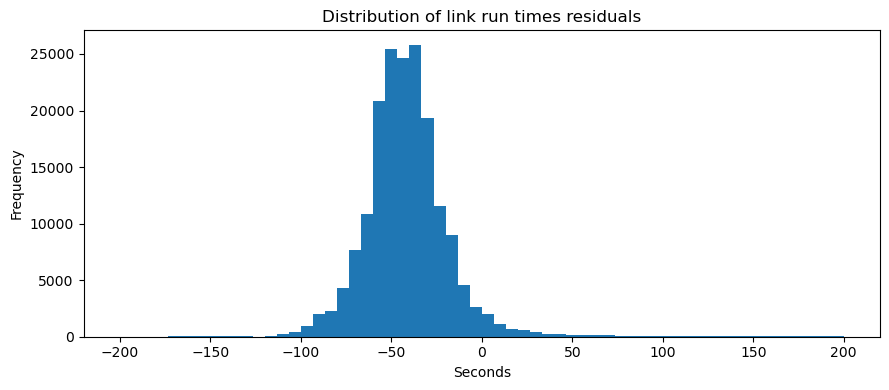

In [76]:
plt.figure(figsize=(9,4))
x = seg["y_resid_s"].dropna()
x = x[(x>=-200) & (x<=200)]
plt.hist(x, bins=60)
plt.title("Distribution of link run times residuals")
plt.xlabel("Seconds"); plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [16]:
# ---- 6) TIME-AWARE SPLIT ----
mask_tr = (seg["link_start_time"]>=pd.to_datetime(TRAIN_FROM)) & (seg["link_start_time"]<=pd.to_datetime(TRAIN_TO))
mask_te = (seg["link_start_time"]>=pd.to_datetime(TEST_FROM))  & (seg["link_start_time"]<=pd.to_datetime(TEST_TO))

train = seg[mask_tr].copy()
test  = seg[mask_te].copy()

# Historical p50/p85 residual (segment × period) from TRAIN (baselines)
hist_p50 = train.groupby(["SegmentKey","period"])["y_resid_s"].median()
hist_p85 = train.groupby(["SegmentKey","period"])["y_resid_s"].quantile(0.85)

def baseline_from_hist(dfX, qmap):
    keys = list(zip(dfX["SegmentKey"], dfX["period"]))
    vals = [qmap.get(k, 0.0) for k in keys]  # fallback to 0 residual if unseen
    return np.array(vals, dtype=float)

def baseline_from_hist_fast(dfX: pd.DataFrame, qseries: pd.Series, default=0.0) -> np.ndarray:
    out = (dfX[["SegmentKey","period"]]
           .merge(qseries.rename("q"),
                  left_on=["SegmentKey","period"],
                  right_index=True,
                  how="left")["q"]
           .fillna(default)
           .to_numpy(dtype=float))
    return out

In [17]:
import time, numpy as np, pandas as pd

def lap(msg, _t=[None]):
    now = time.time()
    if _t[0] is None:
        print(f"[{msg}]"); _t[0] = now
    else:
        print(f"[{msg}] {now - _t[0]:.2f}s"); _t[0] = now

In [18]:
# ========= ROBUST TRAIN BLOCK (diagnose + fix, with EN comments) =========
import os, gc, time, warnings
import numpy as np, pandas as pd, lightgbm as lgb
from pandas.api.types import CategoricalDtype


# ---------------------------
# 0) Utilities: simple timer
# ---------------------------
def lap(msg, _t=[None]):
    """Print a message and elapsed time since last lap()."""
    now = time.time()
    if _t[0] is None:
        print(f"[{msg}]"); _t[0] = now
    else:
        print(f"[{msg}] {now - _t[0]:.2f}s"); _t[0] = now

# ---------------------------
# 1) Thread caps for macOS stability (avoid oversubscription)
# ---------------------------

print("LightGBM:", lgb.__version__)

# ---------------------------
# 2) Time-aware split: small tail of TRAIN as validation
# ---------------------------
VAL_DAYS = 3
val_cut = pd.to_datetime(TRAIN_TO) - pd.Timedelta(days=VAL_DAYS - 1)

lap("split train/val")
train_fit = train[train["link_start_time"] < val_cut].copy()
val_fit   = train[train["link_start_time"] >= val_cut].copy()
print("fit/val/test:", len(train_fit), len(val_fit), len(test))

# If validation is empty (e.g., short window), fallback to VAL_DAYS=1
if len(val_fit) == 0:
    print("⚠️ val is empty; retry with VAL_DAYS=1")
    VAL_DAYS = 1
    val_cut = pd.to_datetime(TRAIN_TO)
    train_fit = train[train["link_start_time"] < val_cut].copy()
    val_fit   = train[train["link_start_time"] >= val_cut].copy()
    print("fit/val/test:", len(train_fit), len(val_fit), len(test))

# ---------------------------
# 3) (Optional) speed-up: downsample training by period (keeps distribution)
# ---------------------------
FAST = True
DEBUG_FRAC = 0.5  # keep 50% for faster iteration; tune as needed
if FAST and len(train_fit) > 40000:
    lap("downsample train by period")
    train_fit = (train_fit
                 .groupby("period", group_keys=False)
                 .apply(lambda x: x.sample(frac=DEBUG_FRAC, random_state=42))
                 .reset_index(drop=True))
    print("downsampled fit:", len(train_fit))

# ---------------------------
# 4) Cap rare categories to reduce cardinality
# ---------------------------
lap("cap_rare categories")
def cap_rare(s: pd.Series, min_count=50):
    vc = s.value_counts()
    keep = set(vc[vc >= min_count].index)
    return s.where(s.isin(keep), "OTHER")

cat_cols = ["from_stop","to_stop","line","dir"]
for c in cat_cols:
    train_fit[c] = cap_rare(train_fit[c].astype(str), 50)
    val_fit[c]   = cap_rare(val_fit[c].astype(str), 50)
    test[c]      = cap_rare(test[c].astype(str), 50)

# ---------------------------
# 5) Build X / y
# ---------------------------
lap("build X/y")
# feat_cols must include your numeric + categorical features in the right order
# e.g.:
# feat_cols = [
#   "distance_m","phys_speed_kmh","dwell_prev_s","ecart_prev_s",
#   "board_prev","alight_prev","hour_sin","hour_cos","dow","is_weekend",
#   "from_stop","to_stop","line","dir"
# ]

X_fit = train_fit[feat_cols].copy()
y_fit = train_fit["y_resid_s"].astype(float).values
X_val = val_fit[feat_cols].copy()
y_val = val_fit["y_resid_s"].astype(float).values
X_te  = test[feat_cols].copy()
y_te  = test["y_resid_s"].astype(float).values
print("X_fit / X_val / X_te:", X_fit.shape, X_val.shape, X_te.shape)

# ---------------------------
# 6) Make categorical vocabularies CONSISTENT across all splits
# ---------------------------
lap("unify categorical vocab")
for c in cat_cols:
    cats = sorted( set(X_fit[c].astype(str))
                 | set(X_val[c].astype(str))
                 | set(X_te[c].astype(str))
                 | {"OTHER"} )
    ctype = CategoricalDtype(categories=cats, ordered=False)
    X_fit[c] = X_fit[c].astype(ctype)
    X_val[c] = X_val[c].astype(ctype)
    X_te[c]  = X_te[c].astype(ctype)

cat_idx = [X_fit.columns.get_loc(c) for c in cat_cols]

# ---------------------------
# 7) Sanitize numerics: no NaN/Inf; drop rows with missing numerics in fit/val
# ---------------------------
lap("sanitize numerics")
num_cols = [c for c in feat_cols if c not in cat_cols]

for Xname, X in [("X_fit", X_fit), ("X_val", X_val), ("X_te", X_te)]:
    X[num_cols] = X[num_cols].replace([np.inf, -np.inf], np.nan)
    # quick report of top NaN rates
    print(f"{Xname} top-NaN rates:\n{X[num_cols].isna().mean().sort_values(ascending=False).head(4)}\n")

fit_mask = np.isfinite(y_fit)
val_mask = np.isfinite(y_val)
fit_mask &= np.all(np.isfinite(X_fit[num_cols].to_numpy()), axis=1)
val_mask &= np.all(np.isfinite(X_val[num_cols].to_numpy()), axis=1)

X_fit = X_fit.iloc[fit_mask].copy(); y_fit = y_fit[fit_mask]
X_val = X_val.iloc[val_mask].copy(); y_val = y_val[val_mask]
print("after drop NaN/Inf ->",
      "X_fit:", X_fit.shape, "X_val:", X_val.shape)

# ---------------------------
# 8) LightGBM params: stable & fast on CPU (row-wise, limited threads)
# ---------------------------
base_params = dict(
    learning_rate=0.10,
    n_estimators=600,          # increase later when everything is stable
    max_depth=6,
    num_leaves=31,
    min_data_in_leaf=500,
    max_bin=63,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    n_jobs=4,                  # important on macOS
    force_row_wise=True,
    max_cat_to_onehot=4,
    max_cat_threshold=16,
    min_data_per_group=100,
    cat_smooth=10,
    verbosity=0                # keep callbacks visible, silence tree-level spam
)

LightGBM: 4.6.0
[split train/val]
fit/val/test: 73940 10043 83337
[downsample train by period] 0.07s
downsampled fit: 36970
[cap_rare categories] 0.12s
[build X/y] 0.06s
X_fit / X_val / X_te: (36970, 14) (10043, 14) (83337, 14)
[unify categorical vocab] 0.02s
[sanitize numerics] 0.06s
X_fit top-NaN rates:
phys_speed_kmh    0.001271
distance_m        0.001244
dwell_prev_s      0.000000
ecart_prev_s      0.000000
dtype: float64

X_val top-NaN rates:
distance_m        0.001494
phys_speed_kmh    0.001494
dwell_prev_s      0.000000
ecart_prev_s      0.000000
dtype: float64

X_te top-NaN rates:
phys_speed_kmh    0.001812
distance_m        0.001452
dwell_prev_s      0.000000
ecart_prev_s      0.000000
dtype: float64

after drop NaN/Inf -> X_fit: (36923, 14) X_val: (10028, 14)


In [22]:
# ---------------------------
# 8) LightGBM params: stable & fast on CPU (row-wise, limited threads)
# ---------------------------
import os, time, gc
import numpy as np
import lightgbm as lgb

# （建議放在最前面的 cell，但這裡再保險一次）
os.environ.setdefault("OMP_NUM_THREADS", "2")          # 先保守，確定不卡再調 4
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("BLIS_NUM_THREADS", "1")

base_params = dict(
    learning_rate=0.10,
    n_estimators=600,          # 先 600，確認穩定後可加
    max_depth=6,
    num_leaves=31,
    min_data_in_leaf=500,
    max_bin=63,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    n_jobs=2,                  # macOS 請避免 -1，穩定後可改 4
    force_row_wise=True,
    max_cat_to_onehot=4,
    max_cat_threshold=16,
    min_data_per_group=100,
    cat_smooth=10
)

# ---------- preflight：檢查資料 ----------
cat_cols = ["from_stop","to_stop","line","dir"]
num_cols = [c for c in feat_cols if c not in cat_cols]

def _assert_ok_split(name, X, y):
    assert isinstance(X, pd.DataFrame), f"{name} must be DataFrame"
    assert isinstance(y, np.ndarray), f"{name} y must be numpy array"
    assert X.shape[0] == len(y), f"{name} X/y length mismatch"
    assert all(c in X.columns for c in feat_cols), f"{name} missing features"
    assert np.isfinite(y).all(), f"{name} y has NaN/Inf"
    bad = X[num_cols].to_numpy()
    assert np.isfinite(bad).all(), f"{name} numeric features have NaN/Inf"

# cast numerics → float32（加速 & 降記憶體）
X_fit[num_cols] = X_fit[num_cols].astype("float32")
X_val[num_cols] = X_val[num_cols].astype("float32")
X_te [num_cols] = X_te [num_cols].astype("float32")

# 重新計算 cat_idx（避免前面有改過欄位順序）
cat_idx = [X_fit.columns.get_loc(c) for c in cat_cols]

# 檢查 split
_assert_ok_split("FIT", X_fit, y_fit)
_assert_ok_split("VAL", X_val, y_val)

# ---------- v1：用原生 categorical（期望印出 log） ----------
print(">>> train p50 (native categorical)", flush=True)
t0 = time.time()
m50 = lgb.LGBMRegressor(objective="regression_l1", **base_params)
m50.fit(
    X_fit, y_fit,
    eval_set=[(X_val, y_val)],
    eval_metric="l1",
    categorical_feature=cat_idx,
    callbacks=[lgb.log_evaluation(period=20),
               lgb.early_stopping(stopping_rounds=30)]
)
print(f"<<< p50 done in {time.time()-t0:.2f}s, best_iter={getattr(m50,'best_iteration_',None)}", flush=True)

gc.collect()

print(">>> train p85 (native categorical)", flush=True)
t1 = time.time()
m85 = lgb.LGBMRegressor(objective="quantile", alpha=0.85, **base_params)
m85.fit(
    X_fit, y_fit,
    eval_set=[(X_val, y_val)],
    eval_metric="quantile",
    categorical_feature=cat_idx,
    callbacks=[lgb.log_evaluation(period=20),
               lgb.early_stopping(stopping_rounds=30)]
)
print(f"<<< p85 done in {time.time()-t1:.2f}s, best_iter={getattr(m85,'best_iteration_',None)}", flush=True)

# 如果到這裡兩個模型都順利印出 [20]/[40] 日誌，就不需要 fallback。
# ---------- 如果上面 30 秒內沒有任何日誌，改走 ordinal fallback ----------
if (time.time() - t0) > 30 and getattr(m50, "best_iteration_", None) is None:
    print("⚠️  No logs within 30s; fallback to ordinal-encoded categoricals.", flush=True)

    def ordinalize(train_s: pd.Series, valid_s: pd.Series, test_s: pd.Series):
        cats = pd.Index(sorted(pd.Series(train_s.astype(str).unique()).tolist()))
        mapping = {k:i for i,k in enumerate(cats)}
        def _map(s): return s.astype(str).map(mapping).fillna(-1).astype("int32")
        return _map(train_s), _map(valid_s), _map(test_s)

    Xo_fit, Xo_val, Xo_te = X_fit.copy(), X_val.copy(), X_te.copy()
    for c in cat_cols:
        Xo_fit[c], Xo_val[c], Xo_te[c] = ordinalize(X_fit[c], X_val[c], X_te[c])

    # 不傳 categorical_feature，讓 LGBM 當一般數值處理
    print(">>> train p50 (ordinal cats)", flush=True)
    t0b = time.time()
    m50 = lgb.LGBMRegressor(objective="regression_l1", **base_params)
    m50.fit(
        Xo_fit[feat_cols], y_fit,
        eval_set=[(Xo_val[feat_cols], y_val)],
        eval_metric="l1",
        callbacks=[lgb.log_evaluation(period=20),
                   lgb.early_stopping(stopping_rounds=30)]
    )
    print(f"<<< p50 done (ordinal) in {time.time()-t0b:.2f}s, best_iter={getattr(m50,'best_iteration_',None)}", flush=True)

    gc.collect()

    print(">>> train p85 (ordinal cats)", flush=True)
    t1b = time.time()
    m85 = lgb.LGBMRegressor(objective="quantile", alpha=0.85, **base_params)
    m85.fit(
        Xo_fit[feat_cols], y_fit,
        eval_set=[(Xo_val[feat_cols], y_val)],
        eval_metric="quantile",
        callbacks=[lgb.log_evaluation(period=20),
                   lgb.early_stopping(stopping_rounds=30)]
    )
    print(f"<<< p85 done (ordinal) in {time.time()-t1b:.2f}s, best_iter={getattr(m85,'best_iteration_',None)}", flush=True)

    # 用 ordinal 的特徵做預測
    print(">>> predict (ordinal)", flush=True)
    pred50 = m50.predict(Xo_te[feat_cols], num_iteration=getattr(m50,"best_iteration_",None))
    pred85 = m85.predict(Xo_te[feat_cols], num_iteration=getattr(m85,"best_iteration_",None))
    print("<<< predict done (ordinal)", flush=True)
else:
    # ---------- v1 正常路徑：用原生 categorical 做預測 ----------
    print(">>> predict", flush=True)
    pred50 = m50.predict(X_te, num_iteration=getattr(m50,"best_iteration_",None))
    pred85 = m85.predict(X_te, num_iteration=getattr(m85,"best_iteration_",None))
    print("<<< predict done", flush=True)

# ---------------------------
# 12) Vectorized historical baselines (no Python loops)
# ---------------------------
lap("hist baselines")
test["period"]  = test["period"].fillna("Other").astype(str)
train["period"] = train["period"].fillna("Other").astype(str)

b_hist50 = (test[["SegmentKey","period"]]
            .merge(hist_p50.rename("q"),
                   left_on=["SegmentKey","period"],
                   right_index=True, how="left")["q"]
            .fillna(0.0).to_numpy(dtype=float))
b_hist85 = (test[["SegmentKey","period"]]
            .merge(hist_p85.rename("q"),
                   left_on=["SegmentKey","period"],
                   right_index=True, how="left")["q"]
            .fillna(0.0).to_numpy(dtype=float))
lap("hist baselines done")

# ---------------------------
# 13) Metrics
# ---------------------------
lap("metrics")
def mae(a, b): return float(np.mean(np.abs(a - b)))
mae_model = mae(y_te, pred50)
mae_hist  = mae(y_te, b_hist50)
mae_zero  = mae(y_te, np.zeros_like(y_te))
cov_model = float(np.mean(y_te <= pred85))   # ~0.85 target
cov_hist  = float(np.mean(y_te <= b_hist85))
lap("metrics done")

print(f"MAE residual (sec) — model p50: {mae_model:.1f} | hist p50: {mae_hist:.1f} | zero: {mae_zero:.1f}")
print(f"Coverage @p85 — model: {cov_model:.3f} | hist: {cov_hist:.3f}")

>>> train p50 (native categorical)
Training until validation scores don't improve for 30 rounds
[20]	valid_0's l1: 11.7538
[40]	valid_0's l1: 10.6329
[60]	valid_0's l1: 10.3522
[80]	valid_0's l1: 10.2256
[100]	valid_0's l1: 10.1449
[120]	valid_0's l1: 10.0761
[140]	valid_0's l1: 10.0297
[160]	valid_0's l1: 9.99675
[180]	valid_0's l1: 9.96568
[200]	valid_0's l1: 9.91696
[220]	valid_0's l1: 9.89276
[240]	valid_0's l1: 9.87882
[260]	valid_0's l1: 9.86165
[280]	valid_0's l1: 9.83857
[300]	valid_0's l1: 9.82688
[320]	valid_0's l1: 9.80931
[340]	valid_0's l1: 9.79634
[360]	valid_0's l1: 9.78627
[380]	valid_0's l1: 9.77541
[400]	valid_0's l1: 9.76776
[420]	valid_0's l1: 9.75612
[440]	valid_0's l1: 9.74836
[460]	valid_0's l1: 9.73909
[480]	valid_0's l1: 9.72916
[500]	valid_0's l1: 9.72488
[520]	valid_0's l1: 9.71722
[540]	valid_0's l1: 9.71517
[560]	valid_0's l1: 9.70816
[580]	valid_0's l1: 9.70145
[600]	valid_0's l1: 9.6663
Did not meet early stopping. Best iteration is:
[600]	valid_0's l1: 9

In [ ]:

# ---- 8) METRICS & BASELINES ----
def mae(a, b): return float(np.mean(np.abs(a-b)))

# Baselines
b_hist50 = baseline_from_hist(test, hist_p50)  # historical median residual
b_hist85 = baseline_from_hist(test, hist_p85)  # historical p85 residual

# Schedule "baseline" is residual=0 ⇒ MAE = mean(|y|)
b_zero = np.zeros_like(y_te)

# Evaluate
mae_model = mae(y_te, pred50)
mae_hist  = mae(y_te, b_hist50)
mae_zero  = mae(y_te, b_zero)

cov_model = float(np.mean(y_te <= pred85))     # should be ~0.85 if well calibrated
cov_hist  = float(np.mean(y_te <= b_hist85))

print(f"[SPLIT] Train {TRAIN_FROM}..{TRAIN_TO} → Test {TEST_FROM}..{TEST_TO}")
print(f"Samples: train={len(train):,}, test={len(test):,}")
print(f"MAE residual (sec):  model p50 = {mae_model:.1f} | hist p50 = {mae_hist:.1f} | zero = {mae_zero:.1f}")
print(f"Coverage @p85:       model = {cov_model:.3f} | hist = {cov_hist:.3f}")

# ---- 9) SIMPLE BREAKDOWNS (by period / by line) ----
def breakdown_mae(df_te, y_true, y_pred, key):
    tmp = df_te[[key]].copy()
    tmp["ae"] = np.abs(y_true - y_pred)
    out = tmp.groupby(key)["ae"].mean().sort_values()
    return out

print("\n[MAE by period] (model p50)")
print(breakdown_mae(test, y_te, pred50, "period"))

if "line" in test.columns:
    print("\n[MAE by line] (model p50)")
    print(breakdown_mae(test, y_te, pred50, "line"))

# ---- 10) FEATURE IMPORTANCE (gain-based) ----
imp = pd.Series(m50.booster_.feature_importance(importance_type="gain"), index=m50.booster_.feature_name())
imp = imp.sort_values(ascending=False)
print("\n[Top features by gain]\n", imp.head(15))



In [ ]:
m50 = lgb.LGBMRegressor(
    objective="regression_l1",
    learning_rate=0.10,
    n_estimators=10,              # 只跑 10 棵，必定很快
    num_leaves=31, max_depth=6, min_data_in_leaf=500,
    max_bin=63, feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
    n_jobs=4,                     # macOS 不要用 -1
    verbosity=0
)
print("[sklearn p50] before fit")
m50.fit(
    X_fit, y_fit,
    eval_set=[(X_val, y_val)],
    eval_metric="l1",
    categorical_feature=[X_fit.columns.get_loc(c) for c in cat_cols],
    callbacks=[lgb.log_evaluation(1), lgb.early_stopping(5)]
)
print("[sklearn p50] after fit, best_iter:", getattr(m50, "best_iteration_", None))